In [1]:
from ipynb.fs.full.GNC import *
from ipynb.fs.full.Draw import *
from ipynb.fs.full.GNCquick import *

In [18]:
#path to the fb data feature map file
pathhack = os.path.dirname(os.path.realpath("C:/Users/pc/Desktop/thesis/data/dataFb/feature_map.txt"))
feat_file_name = "%s/feature_map.txt" % (pathhack,)
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()
ego_nodes = []

#datagiin propertyg unshij avna
def load_features():
    # may need to build the index first
    if not os.path.exists(feat_file_name):
        feat_index = {}
        # build the index from data/*.featnames files
        featname_files = glob.iglob("%s/data/*.featnames" % (pathhack,))
        for featname_file_name in featname_files:
            featname_file = open(featname_file_name, 'r', encoding="utf8")
            for line in featname_file:
                # example line:
                # 0 birthday;anonymized feature 376
                index, name = parse_featname_line(line)
                feat_index[index] = name
            featname_file.close()
        keys = list(feat_index.keys())
        keys.sort()
        out = open(feat_file_name,'w')
        for key in keys:
            out.write("%d %s\n" % (key, feat_index[key]))
        out.close()
        
    # index built, read it in (even if we just built it by scanning)
    global feature_index
    global inverted_feature_index
    index_file = open(feat_file_name,'r')
    for line in index_file:
        split = line.strip().split(' ')
        key = int(split[0])
        val = split[1]
        feature_index[key] = val
    index_file.close()

    for key in feature_index.keys():
        val = feature_index[key]
        inverted_feature_index[val] = key

# # for fb
## line bolgonoos featuree yalgaj avna
def parse_featname_line(line):
    line = line[(line.find(' '))+1:]  # chop first field
    split = line.split(';')
    name = ';'.join(split[:-1]) # feature name
    index = int(split[-1].split(" ")[-1]) #feature index
    return index, name
#for twitter
# def parse_featname_line(line):
#     split = line.split()
#     index = int(split[0])
#     name = split[1]
#     return index, name

#oroiruudaa unshina
def load_nodes():
    assert len(feature_index) > 0, "call load_features() first"
    global network
    global ego_nodes
#     for x in glob.glob("%s/data/*.featnames" % (pathhack,)):
    #print(int(re.search(r'\d+', (x.split("/")[-1].split('.')[0])).group()))
    # get all the node ids by looking at the files
    ego_nodes = [int(re.search(r'\d+', (x.split("/")[-1].split('.')[0])).group()) for x in glob.glob("%s/data/*.featnames" % (pathhack,))]
    node_ids = ego_nodes

    # parse each node
    for node_id in node_ids:
        featname_file = open("%s/data/%d.featnames" % (pathhack,node_id), 'r', encoding="utf8")
        feat_file     = open("%s/data/%d.feat"      % (pathhack,node_id), 'r', encoding="utf8")
        egofeat_file  = open("%s/data/%d.egofeat"   % (pathhack,node_id), 'r', encoding="utf8")
        edge_file     = open("%s/data/%d.edges"     % (pathhack,node_id), 'r', encoding="utf8")

        # parse ego node
        network.add_node(node_id)
        # 0 1 0 0 0 ...
        ego_features = [int(x) for x in egofeat_file.readline().split(' ')]
        i = 0
        network.nodes[node_id]['features'] = np.zeros(len(feature_index))
        for line in featname_file:
            key, val = parse_featname_line(line)
            network.nodes[node_id]['features'][key] = ego_features[i] + 1
            i += 1

        # parse neighboring nodes
        for line in feat_file:
            featname_file.seek(0)
            split = [int(x) for x in line.split(' ')]
            node_id = split[0]
            features = split[1:]
            network.add_node(node_id)
            network.nodes[node_id]['features'] = np.zeros(len(feature_index))
            i = 0
            for line in featname_file:
                key, val = parse_featname_line(line)
                network.nodes[node_id]['features'][key] = features[i]
                i += 1
            
        featname_file.close()
        feat_file.close()
        egofeat_file.close()
        edge_file.close()

#irmeguudee unshina
def load_edges():
    global network
    assert network.order() > 0, "call load_nodes() first"
    edge_file = open("%s/facebook_combined.txt" % (pathhack,),"r")
    for line in edge_file:
        # nodefrom nodeto
        split = [int(x) for x in line.split(" ")]
        node_from = split[0]
        node_to = split[1]
        network.add_edge(node_from, node_to)

#niited ni graphaa unshij avah function
def load_network():
    """
    Load the network.  After calling this function, facebook.network points to a networkx object for the facebook data.
    """
    load_features()
    load_nodes()
    load_edges()

def feature_matrix():
    n_nodes = network.number_of_nodes()
    n_features = len(feature_index)

    X = np.zeros((n_nodes, n_features))
    for i,node in enumerate(network.nodes()):
        X[i,:] = network.node[node]['features']

    return X

def universal_feature(feature_index):
    """
    Does every node have this feature?
    """
    return len([x for x in network.nodes_iter() if network.node[x]['feautures'][feature_index] > 0]) // network.order() == 1


load_network()

In [21]:
##girvan revised on Fb data
start_time1 = time.time()
result = revised_girvan(network)
for i in range(10):
    communities = next(result)
print(str((time.time() - start_time1)) + "seconds")

50.6834933757782seconds


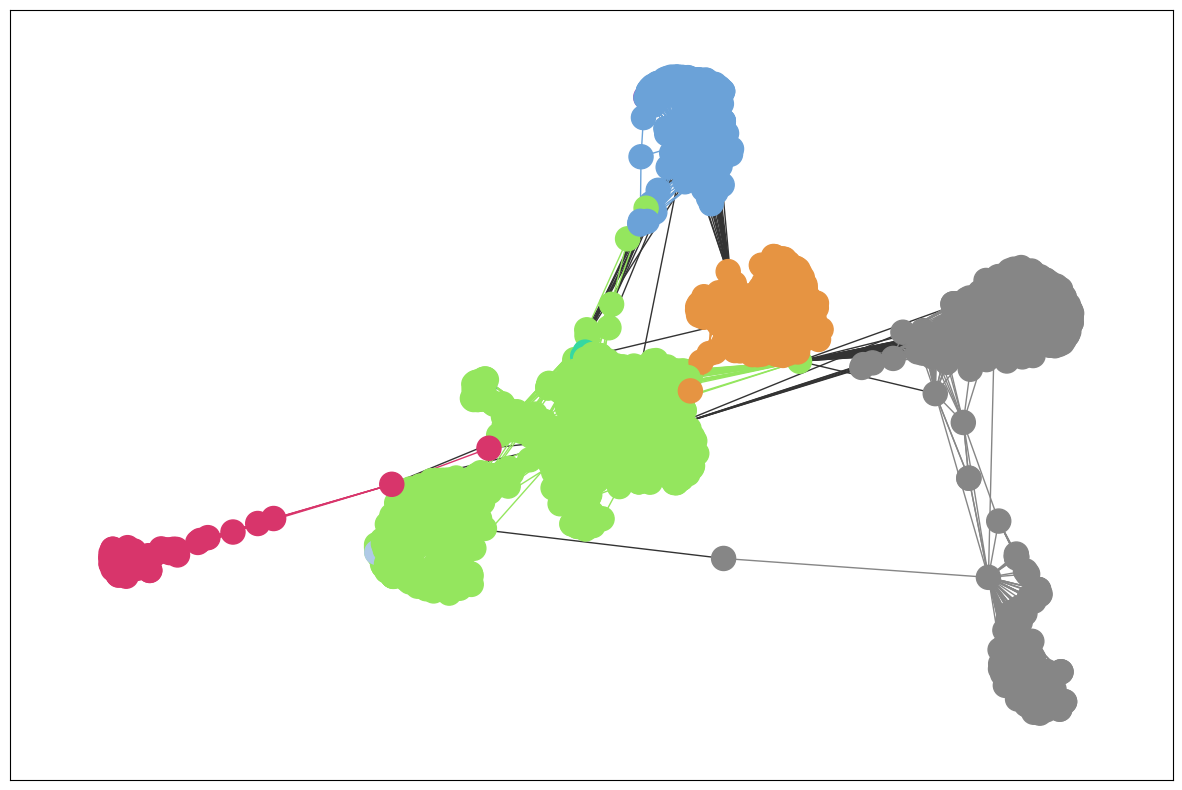

In [22]:
draw_community(network, communities)